# Wallet Churn Prediction: Product & Growth Insights

This notebook translates churn model outputs into actionable product, growth, and retention insights.

Rather than focusing on predictive performance, this stage explores **how churn signals can be operationalized** to:
- Segment wallets by risk level
- Identify intervention opportunities
- Inform product, UX, and incentive strategies

The goal is to demonstrate how behavioral analytics and ML outputs can directly support product decision-making in Web3 ecosystems.


## Product Context

In a real-world setting, churn prediction is valuable only if it leads to action.

Potential stakeholders include:
- Protocol growth teams
- Exchange retention teams
- Wallet product teams
- Ecosystem incentives / rewards programs

This notebook assumes the model is used as a **decision-support tool**, not an automated enforcement system.


In [4]:
import pandas as pd
import numpy as np

# Load engineered features
df = pd.read_parquet("data_samples/wallet_features_engineered.parquet")

df.head()


,wallet_address,tx_count,total_value,avg_tx_value,wallet_lifetime_days,days_since_last_tx,tx_per_day,churned,log_days_since_last_tx,log_tx_per_day,log_wallet_lifetime_days,log_total_value,activity_recency_ratio,lifetime_activity_ratio,log_activity_recency_ratio,log_lifetime_activity_ratio
0,0xBE0eB53F46cd790Cd13851d5EFF43D12404d33E8,1000,3.751824e+11,3.751824e+08,1501,1126,0.6662,1,7.027315,0.510546,7.314553,26.650678,0.000591,0.665779,0.000591,0.510293
1,0x0E58e8993100F1CBe45376c410F97f4893d9BfCD,443,1.963961e+06,4.433320e+03,1121,15,0.3952,0,2.772589,0.333038,7.022868,14.490474,0.024700,0.394831,0.024400,0.332773
2,0x8315177aB297bA92A06054cE80a67Ed4DBd7ed3a,1000,3.642930e+05,3.642930e+02,17,1200,58.8235,1,7.090910,4.091399,2.890372,12.805716,0.048979,55.555556,0.047817,4.035223
3,0x49048044D57e1C92A77f79988d21Fa8fAF74E97e,1000,1.403524e+04,1.403520e+01,27,869,37.0370,1,6.768493,3.638559,3.332205,9.549398,0.042571,35.714286,0.041690,3.603166
4,0x47ac0Fb4F2D84898e4D9E7b4DaB3C24507a6D503,1000,4.120587e+09,4.120587e+06,548,1124,1.8248,1,7.025538,1.038438,6.308098,22.139261,0.001622,1.821494,0.001621,1.037266


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

feature_cols = [
    "log_days_since_last_tx",
    "log_tx_per_day",
    "log_wallet_lifetime_days",
    "log_total_value",
    "log_activity_recency_ratio",
    "log_lifetime_activity_ratio"
]

X = df[feature_cols]
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

df["churn_probability"] = model.predict_proba(X)[:, 1]

# NOTE:
# In production, churn probabilities should be generated on unseen / future data.
# For this analysis, probabilities are used for segmentation and product insight only.


In [8]:
df["churn_risk_segment"] = pd.cut(
    df["churn_probability"],
    bins=[0, 0.3, 0.7, 1.0],
    labels=["Low Risk", "At-Risk", "Dormant"]
)

df["churn_risk_segment"].value_counts(normalize=True)


churn_risk_segment
Dormant     0.771226
Low Risk    0.191038
At-Risk     0.037736
Name: proportion, dtype: float64

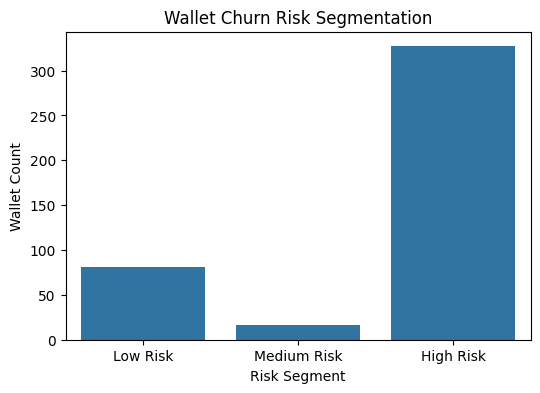

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(
    x="churn_risk_segment",
    data=df,
    order=["Low Risk", "Medium Risk", "High Risk"]
)
plt.title("Wallet Churn Risk Segmentation")
plt.xlabel("Risk Segment")
plt.ylabel("Wallet Count")
plt.show()


In [9]:
segment_profile = (
    df.groupby("churn_risk_segment")[feature_cols]
      .mean()
      .round(2)
)

segment_profile


C:\Users\samis\AppData\Local\Temp\ipykernel_12436\1387736028.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("churn_risk_segment")[feature_cols]


,log_days_since_last_tx,log_tx_per_day,log_wallet_lifetime_days,log_total_value,log_activity_recency_ratio,log_lifetime_activity_ratio
churn_risk_segment,,,,,,
Low Risk,3.35,0.34,6.43,17.99,0.04,0.32
At-Risk,4.79,0.18,6.82,22.08,0.00,0.17
Dormant,6.89,1.31,4.82,18.91,0.06,1.21


## Product Interpretation

The churn model enables segmentation of wallets into actionable risk tiers:

### Low Risk
- Recently active wallets
- High engagement frequency
- Likely retained without intervention

### Medium Risk
- Declining activity patterns
- Early warning signals
- Best candidates for lightweight nudges or incentives

### High Risk
- Extended inactivity
- Low engagement ratios
- Priority targets for reactivation or win-back campaigns


## Potential Intervention Strategies

| Risk Segment | Strategy Type | Example Actions |
|-------------|--------------|-----------------|
| Low Risk | Maintain Engagement | Feature education, new product announcements |
| Medium Risk | Prevent Churn | Targeted incentives, gas rebates, UX reminders |
| High Risk | Reactivation | Token rewards, personalized reactivation campaigns |

This framework allows growth teams to allocate resources efficiently rather than applying uniform incentives across all users.


## Business Impact Summary

This project demonstrates how on-chain behavioral data can be transformed into:
- Interpretable churn signals
- Actionable wallet risk segmentation
- Product and growth decision frameworks

Rather than treating churn prediction as a purely technical exercise, this approach bridges analytics, machine learning, and product strategy — a critical capability for data roles in Web3 and fintech environments.
